In [1]:
from scripts.config import SRC_DIR
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from subprocess import check_output

Read the data from trian and members and merge

In [2]:
train = pd.read_csv(SRC_DIR / "data/internal/train.csv")
members = pd.read_csv(SRC_DIR / "data/internal/members.csv")
members_training = pd.merge(left=train,
                            right=members,
                            how='left',
                            on='msno')
members_training.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18.0,36.0,female,9.0,20050406.0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10.0,38.0,male,9.0,20050407.0
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11.0,27.0,female,9.0,20051016.0
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13.0,23.0,female,9.0,20051102.0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3.0,27.0,male,9.0,20051228.0


Veamos ahora la distribución de nulls, tipos de datos y demás

In [3]:
members_training.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992931 entries, 0 to 992930
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    992931 non-null  object 
 1   is_churn                992931 non-null  int64  
 2   city                    877161 non-null  float64
 3   bd                      877161 non-null  float64
 4   gender                  391692 non-null  object 
 5   registered_via          877161 non-null  float64
 6   registration_init_time  877161 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 53.0+ MB


In [4]:
members_training.describe()

,is_churn,city,bd,registered_via,registration_init_time
count,992931.000000,877161.000000,877161.000000,877161.000000,8.771610e+05
mean,0.063923,5.882329,13.453973,6.911228,2.013228e+07
std,0.244616,6.423447,20.226865,1.904441,2.973484e+04
min,0.000000,1.000000,-3152.000000,3.000000,2.004033e+07
25%,0.000000,1.000000,0.000000,7.000000,2.012021e+07
50%,0.000000,1.000000,0.000000,7.000000,2.014051e+07
75%,0.000000,13.000000,27.000000,9.000000,2.016011e+07
max,1.000000,22.000000,2016.000000,13.000000,2.017033e+07


Cambiamos el formato de las fechas a yyyy-mm-dd para una lectura más sencilla

In [5]:
def convert_date(yyyymmdd):
    if pd.isna(yyyymmdd):
        return np.nan
    yyyymmdd_str = str(int(yyyymmdd))  # Convert to integer first to remove decimal part, then back to string
    yyyy = yyyymmdd_str[:4]
    mm = yyyymmdd_str[4:6]
    dd = yyyymmdd_str[6:]
    return f"{yyyy}-{mm}-{dd}"
members_training['registration_init_time'] = members_training['registration_init_time'].apply(convert_date)

In [6]:
members_training.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18.0,36.0,female,9.0,2005-04-06
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10.0,38.0,male,9.0,2005-04-07
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11.0,27.0,female,9.0,2005-10-16
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13.0,23.0,female,9.0,2005-11-02
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3.0,27.0,male,9.0,2005-12-28


Estudiaremos ahora la distribución de datos para city, gender, edad. En primer lugar trataremos los NAN de manera 
adecuada para poder representarlos correcatmente, 

In [7]:
members_training["city"] = members_training["city"].apply(lambda x: int(x) if pd.notnull(x) else "NAN")
members_training["bd"] = members_training["bd"].apply(lambda x: int(x) if pd.notnull(x) else "NAN")
members_training["registered_via"] = members_training["registered_via"].apply(lambda x: int(x) if pd.notnull(x) else "NAN")
members_training["gender"] = members_training["gender"].fillna("NAN")

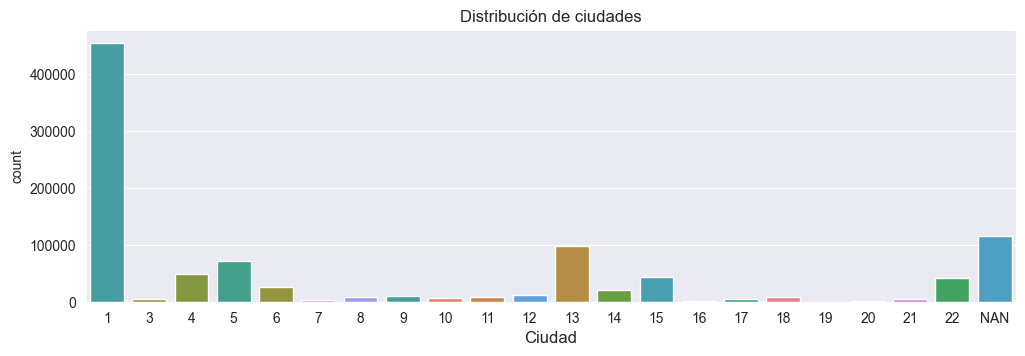

In [8]:
# PAra las ciudades
plt.figure(figsize=(12,12))
plt.subplot(311)
city_order = members_training['city'].unique()
city_order=sorted(city_order, key=lambda x: float(x))
sns.countplot(x="city", data=members_training , order = city_order, hue="city", legend=False)
plt.xlabel('Ciudad', fontsize=12)
plt.title("Distribución de ciudades", fontsize=12)
plt.show()

In [9]:
tmp_1=members_training.bd.unique()
tmp_1

array([36, 38, 27, 23, 29, 22, 31, 43, 47, 42, 33, 25, 28, 26, 20, 37, 34,
       16, 0, 39, 35, 'NAN', 46, 21, 24, 19, 40, 32, 30, 17, 18, 44, 57,
       49, 51, 114, 41, 54, 53, 48, 14, 45, 98, 60, 62, 55, 56, 50, 15,
       52, 68, 58, 89, 63, 65, 105, 72, 11, 102, 13, 66, 61, 6, 101, 64,
       97, 59, 109, 12, 83, 106, 104, 92, 94, 810, 112, 67, 75, 821, -43,
       117, 69, 3, 79, 1029, 81, 945, 7, 70, 77, 111, 107, 2, 71, -48,
       129, 91, 73, 1036, 1, 103, 4, 76, 116, 99, 1051, 96, 74, 95, 1030,
       90, -42, 939, 80, -50, 826, 933, 1033, 1213, 78, 10, -49, 964, 8,
       1040, -51, -5, -36, 86, 1052, 1035, 128, -44, -7, 319, -39, 84, 85,
       820, 82, 1041, -45, 9, 1820, 1043, -3152, 948, -2828, 951, -19,
       153, 936, 1042, 197, 743, 1026, 110, 5, 323, 122, 928, 931, 132,
       100, 93, 119, 113, 1970, 1111, 88, 220, 320, 1028, 1037, 123, -34,
       -41, 934, 1034, 930, -47, 137, 1022, 837, 1053, 946, 1038, 778,
       139, 1421, -9, 160, 1048, 941, 131, 1032, 906

Mean of Birth Date = 29.95164026713142
Median of Birth Date = 28.0


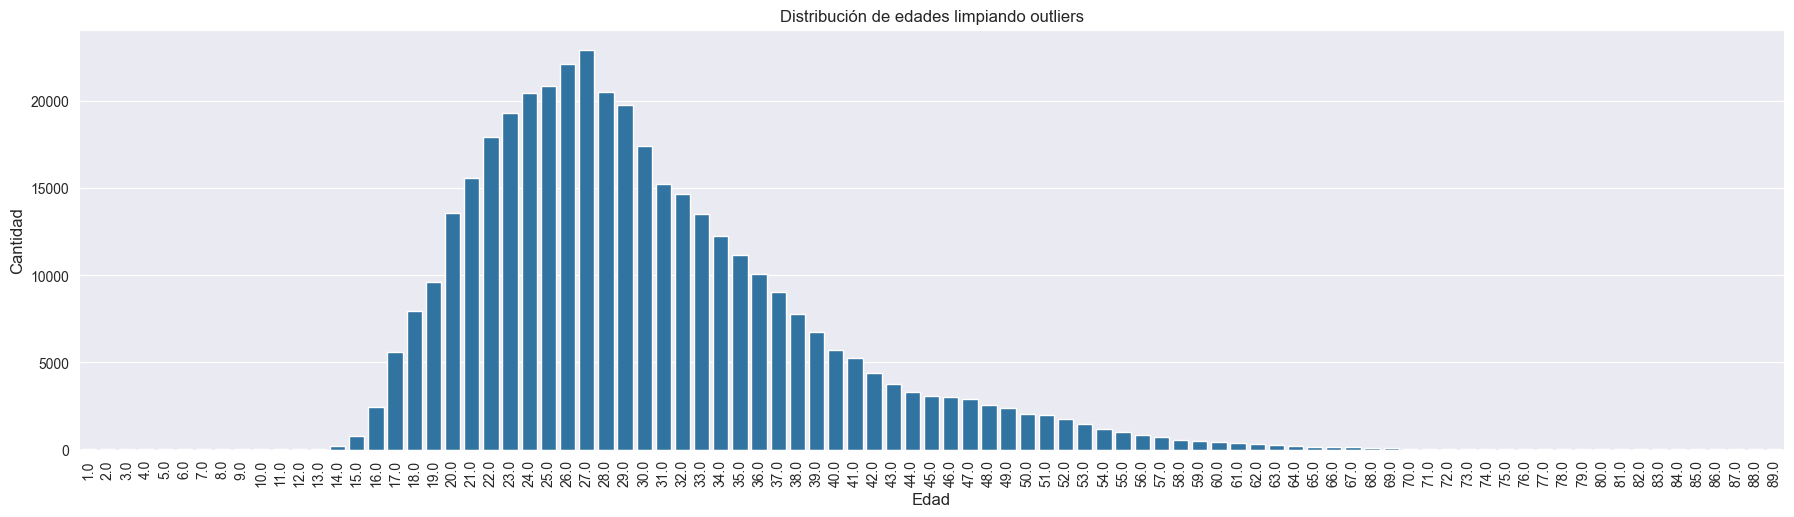

In [23]:
# Dejamos fuera los NAN, las mayores de 90 y las menos de 0
members_training["bd"] = members_training["bd"].astype(float)
tmp_bd = members_training[(members_training.bd != "NAN") & (members_training.bd > 0) & (members_training.bd < 90)]
print("Mean of Birth Date = " +str(np.mean(tmp_bd['bd'])))
print("Median of Birth Date = " +str(np.median(tmp_bd['bd'])))
#print("Mode of Birth Date = " +str(np.mode(tmp_bd['bd'])))
plt.figure(figsize=(22,12))
plt.subplot(211)
bd_order_2 = tmp_bd['bd'].unique()
bd_order_2 = sorted(bd_order_2, key=lambda x: float(x))
sns.countplot(x="bd", data=tmp_bd , order = bd_order_2)
plt.ylabel('Cantidad', fontsize=12)
plt.xlabel('Edad', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribución de edades limpiando outliers", fontsize=12)
plt.show()

# plt.figure(figsize=(4,12))
# plt.subplot(212)
# sns.boxplot(y=tmp_bd["bd"],data=tmp_bd)
# plt.xlabel('BD', fontsize=12)
# plt.title("Box Plot of Birth Date without ouliers and NAN values", fontsize=12)
# plt.show()

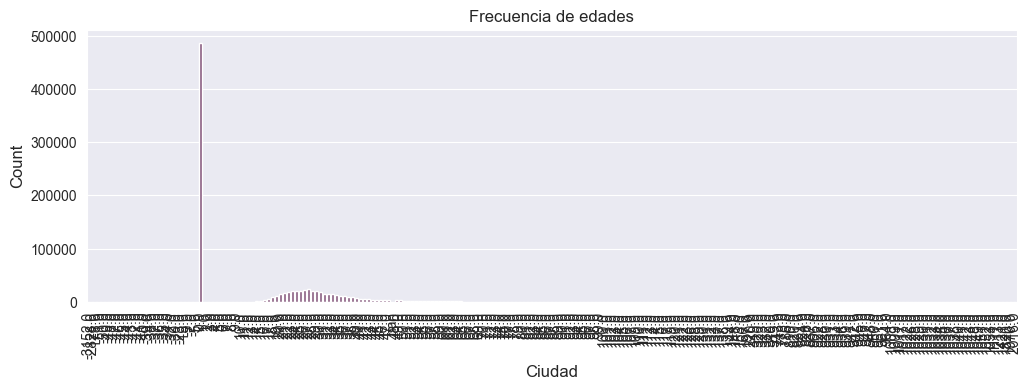

In [12]:
# PAra las edades // muchos null agrupamos
plt.figure(figsize=(12,12))
plt.subplot(311)
bd_order = members_training['bd'].unique()
bd_order=sorted(bd_order, key=lambda x: float(x))
sns.countplot(x="bd", data=members_training , order = bd_order, hue="bd", legend=False)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Ciudad', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frecuencia de edades", fontsize=12)
plt.show()

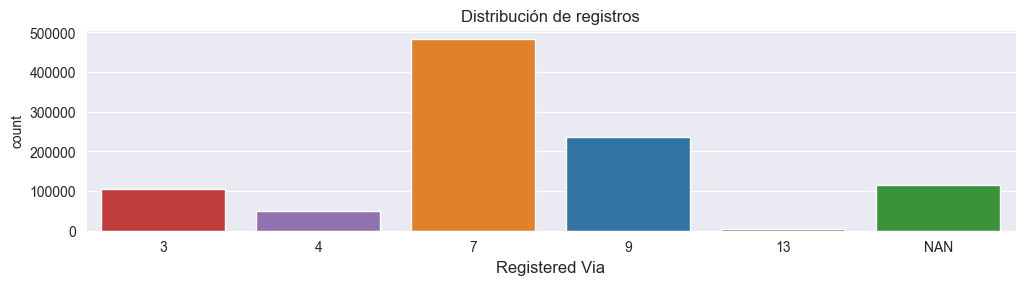

In [13]:
# Para los registros
plt.figure(figsize=(12,12))
plt.subplot(412)
registeredvia_unique = members_training['registered_via'].unique()
registeredvia_unique = sorted(registeredvia_unique, key=lambda x: str(x))
registeredvia_unique = sorted(registeredvia_unique, key=lambda x: float(x))

sns.countplot(x="registered_via", data=members_training, order = registeredvia_unique, hue="registered_via", 
              legend=False)
plt.xlabel('Registered Via', fontsize=12)
plt.title("Distribución de registros", fontsize=12)
plt.show()
RV_count = Counter(members_training['registered_via']).most_common()


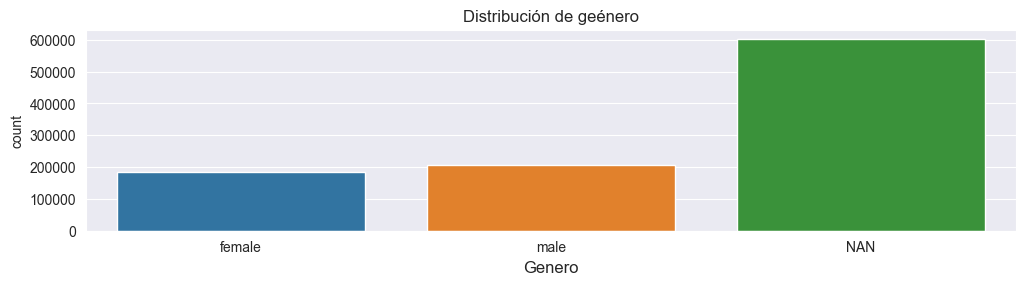

In [14]:
#Genero
plt.figure(figsize=(12,12))
plt.subplot(413)
sns.countplot(x="gender", data=members_training, hue="gender", legend=False)
plt.xlabel('Genero', fontsize=12)
plt.title("Distribución de geénero", fontsize=12)
plt.show()

Ahora analizaremos el registration_time por años, meses y días, también por días de la semana

In [15]:
members_training['registration_init_time_year'] = pd.DatetimeIndex(members_training['registration_init_time']).year
members_training['registration_init_time_month'] = pd.DatetimeIndex(members_training['registration_init_time']).month
members_training['registration_init_time_day'] = pd.DatetimeIndex(members_training['registration_init_time']).day
members_training['registration_init_time_weekdaday'] = (pd.DatetimeIndex(members_training['registration_init_time'])
                                                      .day_name())
members_training.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,registration_init_time_year,registration_init_time_month,registration_init_time_day,registration_init_time_weekdaday
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18,36.0,female,9,2005-04-06,2005.0,4.0,6.0,Wednesday
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38.0,male,9,2005-04-07,2005.0,4.0,7.0,Thursday
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11,27.0,female,9,2005-10-16,2005.0,10.0,16.0,Sunday
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13,23.0,female,9,2005-11-02,2005.0,11.0,2.0,Wednesday
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3,27.0,male,9,2005-12-28,2005.0,12.0,28.0,Wednesday


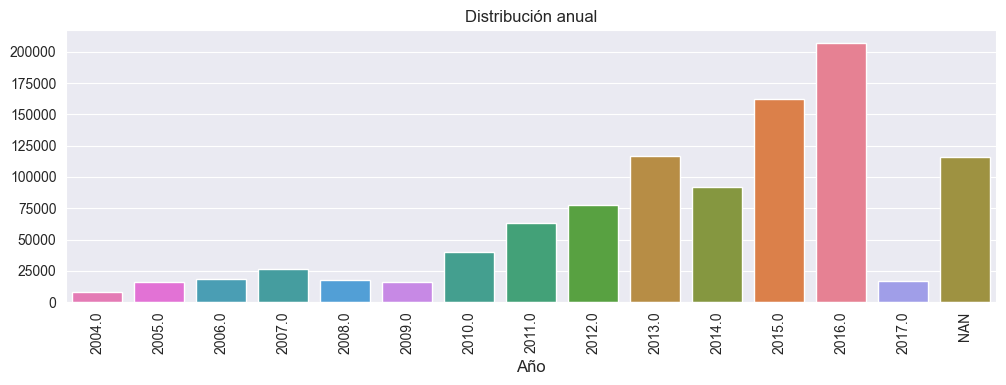

In [16]:
# Trends anuales
members_training['registration_init_time_year'] = members_training['registration_init_time_year'].apply(lambda x: x 
if pd.notnull(x) else "NAN" )
year_count=members_training['registration_init_time_year'].value_counts()
#print(year_count)
plt.figure(figsize=(12,12))
plt.subplot(311)
year_order = members_training['registration_init_time_year'].unique()
year_order=sorted(year_order, key=lambda x: str(x))
year_order = sorted(year_order, key=lambda x: float(x))
sns.barplot(x=year_count.index, y=year_count.values,order=year_order, hue=year_count.index, legend=False)
plt.xlabel('Año', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribución anual", fontsize=12)
plt.show()


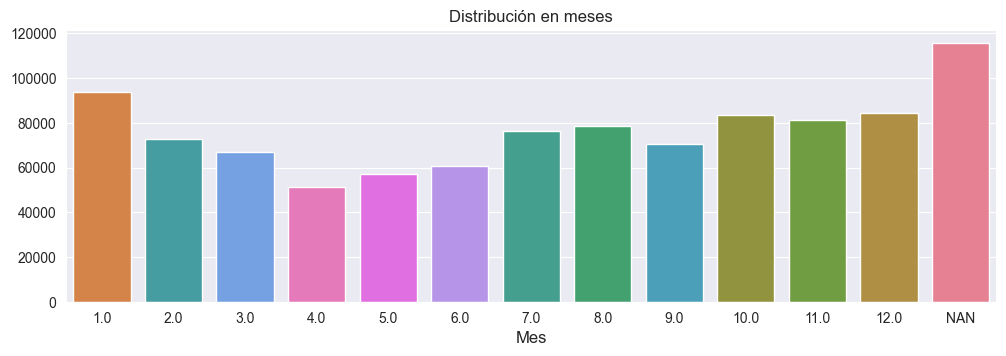

In [17]:
#registration_init_time monthly trend
members_training['registration_init_time_month'] = members_training.registration_init_time_month.apply(lambda x: x if
pd.notnull(x) 
else "NAN" )
month_count=members_training['registration_init_time_month'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(312)
month_order = members_training['registration_init_time_month'].unique()
month_order = sorted(month_order, key=lambda x: str(x))
month_order = sorted(month_order, key=lambda x: float(x))
sns.barplot(x=month_count.index, y=month_count.values,order=month_order, hue=month_count.index, legend=False)
plt.xlabel('Mes', fontsize=12)
plt.title("Distribución en meses", fontsize=12)
plt.show()


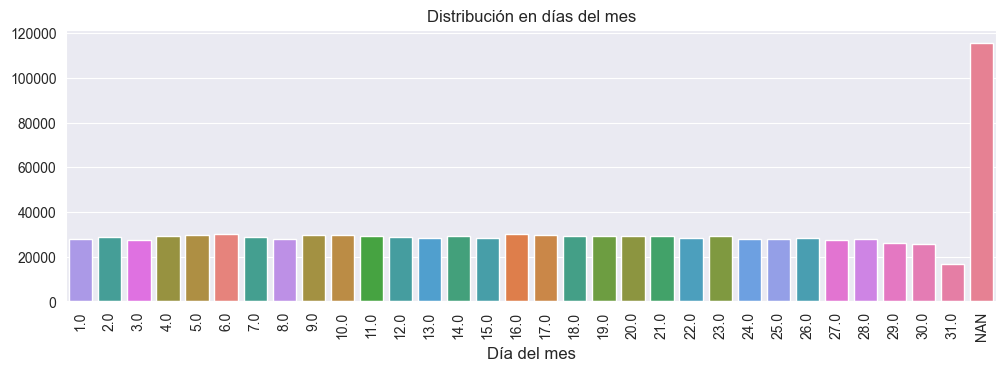

In [18]:
#day of month
members_training['registration_init_time_day'] = members_training.registration_init_time_day.apply(lambda x: x if
pd.notnull(x) 
else "NAN" )
day_count=members_training['registration_init_time_day'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(312)
day_order = members_training['registration_init_time_day'].unique()
day_order = sorted(day_order, key=lambda x: str(x))
day_order = sorted(day_order, key=lambda x: float(x))
sns.barplot(x=day_count.index, y=day_count.values,order=day_order, hue=day_count.index, legend=False)
plt.xlabel('Día del mes', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribución en días del mes", fontsize=12)
plt.show()


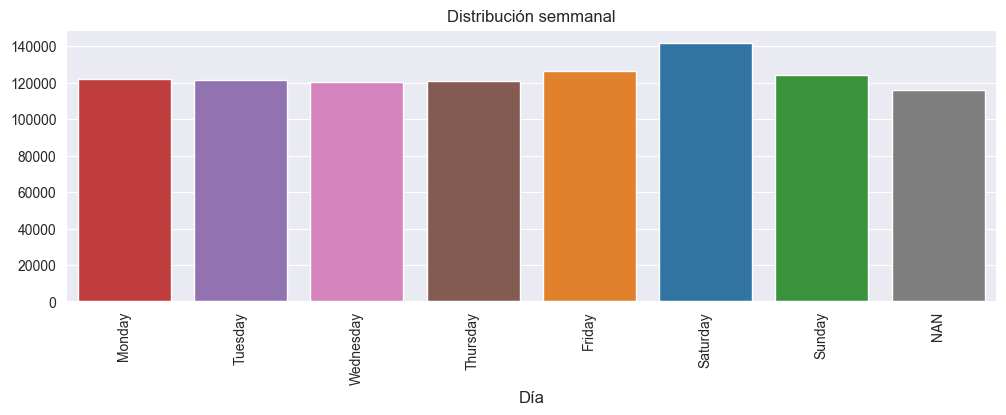

In [19]:
#registration_init_time day wise trend

members_training['registration_init_time_weekdaday'] = members_training.registration_init_time_weekdaday.apply(lambda x: str(x) if pd.notnull(x) else "NAN" )
day_count=members_training['registration_init_time_weekdaday'].value_counts()
plt.figure(figsize=(12,12))
plt.subplot(313)
#day_order = training['registration_init_time_day'].unique()
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','NAN']
sns.barplot(x=day_count.index, y=day_count.values,order=day_order, hue=day_count.index, legend=False)
plt.xlabel('Día', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Distribución semmanal", fontsize=12)
plt.show()

VEamos ahora la relacion de los datos

is_churn,0,1,Ratio
gender,,,
NAN,572026,29213,0.051069
female,169395,16013,0.094531
male,188039,18245,0.097028


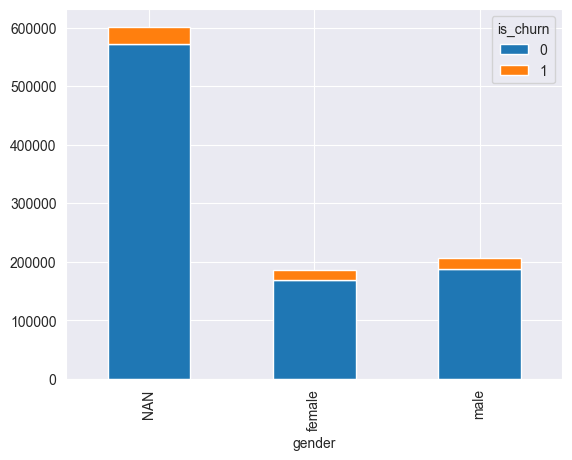

In [20]:
gender_crosstab=pd.crosstab(members_training['gender'],members_training['is_churn'])
gender_crosstab.plot(kind='bar', stacked=True, grid=True)
gender_crosstab["Ratio"] =  gender_crosstab[1] / gender_crosstab[0]
gender_crosstab

is_churn,0,1,Ratio
registered_via,,,
3,92044,13401,0.145593
4,40286,8997,0.223328
7,468167,14559,0.031098
9,216185,20435,0.094526
13,2824,263,0.093130
NAN,109954,5816,0.052895


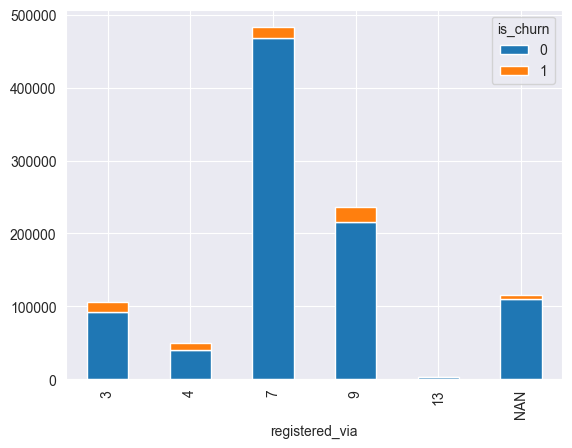

In [21]:
#Registered Via
registered_via_crosstab=pd.crosstab(members_training['registered_via'],members_training['is_churn'])
registered_via_crosstab.plot(kind='bar', stacked=True, grid=True)
registered_via_crosstab["Ratio"] =  registered_via_crosstab[1] / registered_via_crosstab[0]
registered_via_crosstab

is_churn,0,1,Ratio
city,,,
1,433343,22046,0.050874
3,4667,422,0.090422
4,43681,4264,0.097617
5,65051,6248,0.096048
6,23783,2239,0.094143
7,2480,186,0.075000
8,6946,744,0.107112
9,8790,768,0.087372
10,5938,595,0.100202


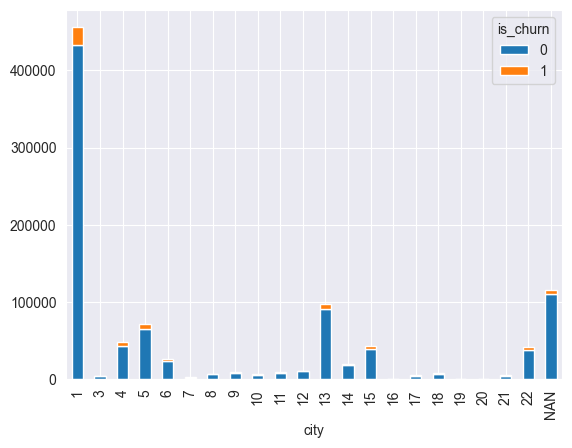

In [22]:
#city
city_crosstab=pd.crosstab(members_training['city'],members_training['is_churn'])
city_crosstab.plot(kind='bar', stacked=True, grid=True)
city_crosstab["Ratio"] =  city_crosstab[1] / city_crosstab[0]
city_crosstab

In [25]:
members.corr(numeric_only=True)

,city,bd,registered_via,registration_init_time
city,1.000000,0.493381,0.129857,-0.418138
bd,0.493381,1.000000,0.052234,-0.369987
registered_via,0.129857,0.052234,1.000000,-0.448156
registration_init_time,-0.418138,-0.369987,-0.448156,1.000000


In [43]:
members_training["city"] = members_training["city"].replace("NAN", np.nan).astype(float)
members_training["registration_init_time_day"] = members_training["registration_init_time_day"].replace("NAN", np.nan).astype(float)
members_training["registration_init_time_month"] = members_training["registration_init_time_month"].replace("NAN", np
                                                                                                        .nan).astype(float)
members_training["registration_init_time_year"] = (members_training["registration_init_time_year"].replace("NAN", np
                                                                                                           .nan)
                                                   .astype(float))
members_training["gender_number"] = np.where(members_training["gender"]=="male",0,1) 
members_training.corr(numeric_only=True)

,is_churn,city,bd,registration_init_time_year,registration_init_time_month,registration_init_time_day,gender_number
is_churn,1.000000,0.054358,0.042350,0.025810,-0.022558,-0.005590,-0.051338
city,0.054358,1.000000,0.512678,-0.360908,-0.023055,0.001603,-0.429694
bd,0.042350,0.512678,1.000000,-0.389436,-0.019656,0.004090,-0.433486
registration_init_time_year,0.025810,-0.360908,-0.389436,1.000000,-0.050633,-0.020778,0.272611
registration_init_time_month,-0.022558,-0.023055,-0.019656,-0.050633,1.000000,0.017019,0.010904
registration_init_time_day,-0.005590,0.001603,0.004090,-0.020778,0.017019,1.000000,-0.001415
gender_number,-0.051338,-0.429694,-0.433486,0.272611,0.010904,-0.001415,1.000000


In [34]:
members_training.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,registration_init_time_year,registration_init_time_month,registration_init_time_day,registration_init_time_weekdaday
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,18,36.0,female,9,2005-04-06,2005.0,4.0,6.0,Wednesday
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,10,38.0,male,9,2005-04-07,2005.0,4.0,7.0,Thursday
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,11,27.0,female,9,2005-10-16,2005.0,10.0,16.0,Sunday
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,13,23.0,female,9,2005-11-02,2005.0,11.0,2.0,Wednesday
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,3,27.0,male,9,2005-12-28,2005.0,12.0,28.0,Wednesday


In [40]:
members_training["city"] = members_training["city"].replace("NAN", np.nan).astype(float)

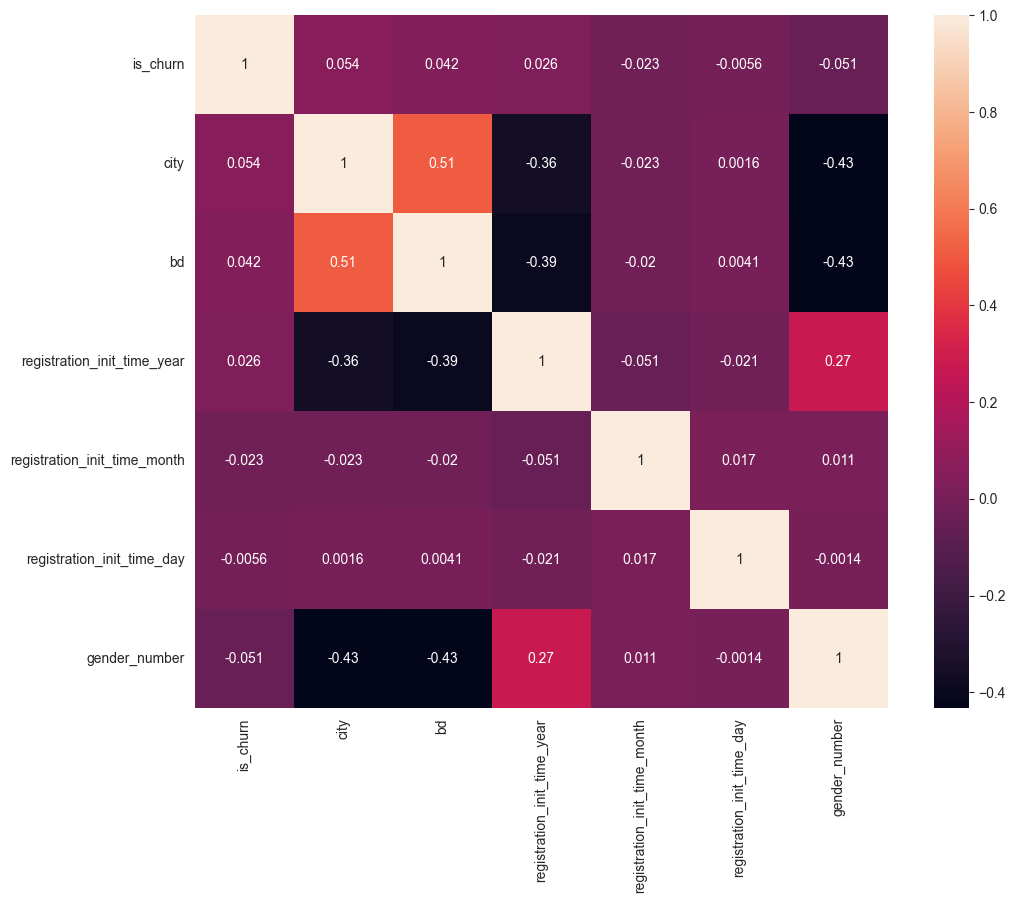

In [45]:
import seaborn as sns
corrmat = members_training.corr(numeric_only=True)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=1, cbar=True, annot=True, square=True);
plt.show()